<a href="https://colab.research.google.com/github/Mahshad-RM/MOR/blob/main/AssignmentsPart_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*
     import dlroms.fespaces as fe

In [2]:
import numpy as np
import importlib
import dispenser
importlib.reload(dispenser)

from dispenser import FOMsolver, FOMsolverhom, Vh, Vb, compute_basis_functions

# **Assignments Part 1**
# 📘 Introduction

This notebook presents a **reduced-order modeling (ROM)** study of a **parametrized advection-diffusion problem** using a **POD-Galerkin** approach. The goal is to reduce the computational cost of solving the full-order problem (FOM) while maintaining accuracy, by projecting the governing equations onto a low-dimensional subspace constructed from high-fidelity snapshots.

---

## 🔍 Problem Overview

This project focuses on the simulation of a **chemical dispenser** system, where the goal is to precisely control the flow and mixing of chemicals using fluid dynamics. The system must ensure:
- Accurate dosing
- Minimal chemical waste
- Safe handling of hazardous substances

### 🧪 Physical Setup

The prototype dispenser consists of a 2D tank with two inflow gates and two outflow gates:

- **Top inflow gate** \( \Gamma_{\text{in},1} \): where the chemical is introduced.
- **Bottom-left inflow gate** \( \Gamma_{\text{in},2} \): used to control additional fluid injection.
- **Outflow gates** \( \Gamma_{\text{out},1} \) and \( \Gamma_{\text{out},2} \): where the chemical exits.

The flow configuration is controlled by three parameters:
- \( c_1 \): horizontal velocity at \( \Gamma_{\text{in},1} \)
- \( c_2 \), \( c_3 \): horizontal and vertical velocities at \( \Gamma_{\text{in},2} \)

---

### 🌊 Governing Equations

#### 1. Stokes Equation (for fluid velocity \( \mathbf{b} \))
To model the fluid motion inside the tank, we solve the stationary incompressible Stokes equations:

\[
\begin{cases}
- \Delta \mathbf{b} - \nabla p = 0 & \text{in } \Omega, \\
\nabla \cdot \mathbf{b} = 0 & \text{in } \Omega, \\
\mathbf{b} = [c_1, 0]^\top & \text{on } \Gamma_{\text{in},1}, \\
\mathbf{b} = [c_2, c_3]^\top & \text{on } \Gamma_{\text{in},2}, \\
\mathbf{b} = 0 & \text{on } \partial \Omega \setminus (\Gamma_{\text{in},1} \cup \Gamma_{\text{in},2})
\end{cases}
\]

Here, \( \mathbf{b}: \Omega \rightarrow \mathbb{R}^2 \) is the velocity field and \( p \) is the pressure.

---

#### 2. Advection-Diffusion Equation (for chemical concentration \( u \))
After computing the velocity field, we simulate the chemical concentration \( u(x,t) \) using a time-dependent advection-diffusion equation:

\[
\begin{cases}
\frac{\partial u}{\partial t} - \Delta u + \mathbf{b} \cdot \nabla u = 0 & \text{in } \Omega \times (0,T), \\
\nabla u \cdot \mathbf{n} = 0 & \text{on } (\partial \Omega \setminus \Gamma_{\text{in},1}) \times (0,T), \\
u = 1 & \text{on } \Gamma_{\text{in},1} \times (0,T), \\
u(x, 0) = \chi_{\Gamma_{\text{in},1}}(x) & \text{in } \Omega.
\end{cases}
\]

This models how the chemical introduced at the top gate gets transported and diffused through the tank under the influence of the flow field \( \mathbf{b} \).

---

### 🎯 Objective

Before proceeding with physical testing, the goal is to **simulate the system numerically** to understand how the design parameters \( c_1, c_2, c_3 \) influence the chemical distribution. This involves solving the coupled Stokes and advection-diffusion equations efficiently, and eventually constructing a reduced-order model (ROM) for rapid simulations.



---

## ⚙️ Structure of This Notebook

- External Python files (`.py`) are used to organize reusable code such as solvers and matrix assembly routines.
- Data used for training and testing (e.g., solution snapshots, POD basis) are stored in `.npy` or `.npz` files to improve reproducibility and reduce runtime.
- Visualization and postprocessing steps are included for analyzing both FOM and ROM results.

---

This notebook provides a complete pipeline for building and validating a reduced-order model for a parametrized PDE, following best practices in scientific computing: separation of code, data reuse, and reproducible analysis.


## 🧮 Task 1: Reformulating the Advection-Diffusion Problem

In this task, we reformulate the original advection-diffusion equation by introducing a **homogenized variable** $u_{\text{hom}} := u - 1$. This change simplifies the boundary conditions, as the Dirichlet condition on $\Gamma_{\text{in},1}$ becomes homogeneous.

We show that the solution $u$ can be expressed as:
$$
u = u_{\text{hom}} + 1,
$$
where $u_{\text{hom}}$ satisfies an advection-diffusion equation with a velocity field defined as a linear combination of three precomputed basis functions $b_1, b_2, b_3$, each corresponding to a unit value of $c_i$ and zero for the others.



In [12]:
# Computes the velocity fields for unit inflow parameter for reuse in linear combinations.
b1, b2, b3 = compute_basis_functions()
dispenser.b1 = b1
dispenser.b2 = b2
dispenser.b3 = b3

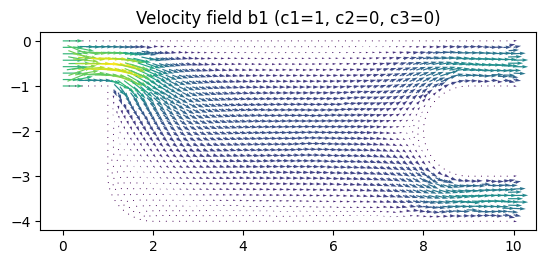

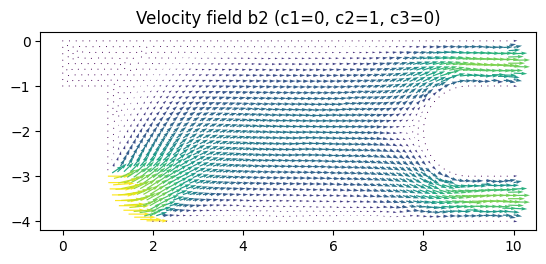

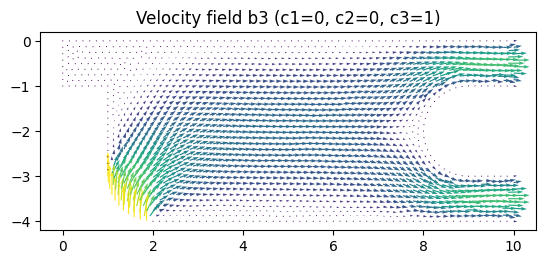

In [4]:
import matplotlib.pyplot as plt
from fenics import plot

# Convert to FEniCS Function for plotting
bf1 = fe.asfunction(b1, Vb)
bf2 = fe.asfunction(b2, Vb)
bf3 = fe.asfunction(b3, Vb)

# Plot b1
plt.figure()
plot(bf1, title="Velocity field b1 (c1=1, c2=0, c3=0)")
plt.show()

# Plot b2
plt.figure()
plot(bf2, title="Velocity field b2 (c1=0, c2=1, c3=0)")
plt.show()

# Plot b3
plt.figure()
plot(bf3, title="Velocity field b3 (c1=0, c2=0, c3=1)")
plt.show()


In [5]:
c0= np.array([40, 20, 30])
u = FOMsolver(*c0)
u.shape


(701, 1940)

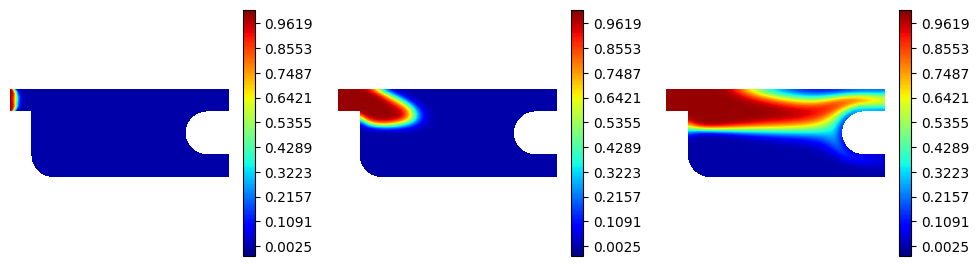

In [6]:
fe.multiplot(u[[10, 200, 700]], (1, 3), Vh, vmin=u.min(), vmax=u.max(),colorbar = True)

In [7]:
uhom, *_ =FOMsolverhom(*c0)
uhom.shape

(701, 1940)

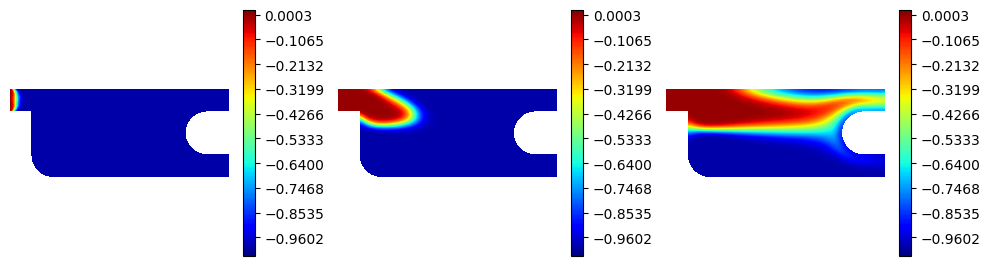

In [8]:
fe.multiplot(uhom[[10, 200, 700]], (1, 3), Vh, vmin=uhom.min(), vmax=uhom.max(), colorbar = True)

In [9]:
# Verify that u = uₕₒₘ + 1
error = np.max(np.abs(u - (uhom + 1)))
print(f"Maximum error between u and uₕₒₘ + 1: {error}")

Maximum error between u and uₕₒₘ + 1: 0.00716084910853515


In [ ]:
#fe.animate(u[::10], Vh)

In [ ]:
#fe.animate(u_hom[::10], Vh)

In [10]:
from dispenser import bottomOutflow

print(bottomOutflow(u))
print(bottomOutflow(uhom))

0.022940463063376885
-0.9769096209275409


## 🧮 Task 2: Data Generation and POD Analysis
In this task, we will generate the data required to build a Reduced Order Model (ROM). We will create a dataset by running 20 simulations with randomly sampled parameters μ=[ $c_1,c_2,c_3$]. After splitting this data, we will analyze the resulting "snapshot matrix" using Singular Value Decomposition. The goal is to study the decay of the singular values to determine the optimal number of basis functions for an efficient POD-Galerkin ROM.

In [ ]:
np.random.seed(0)

nsim = 20
cList = []
uhomList = []

for j in range(nsim):
  cj = 50 * np.random.rand(3)
  uhomj, u0j = FOMsolverhom(*cj)

  cList.append(cj)
  uhomList.append(uhomj)


In [ ]:
c = np.stack(cList)
uhom = np.stack(uhomList)
c.shape

(20, 3)

In [ ]:
uhom.shape # snapshots matrix: Nh x Nsamples

(20, 701, 1940)

In [ ]:
ntrain = nsim // 2
Utrain = uhom[:ntrain].reshape(-1, Vh.dim()).T
Utrain.shape

(1940, 7010)

In [ ]:
from scipy.linalg import svd
X, s, Yt = svd(Utrain, full_matrices = False)


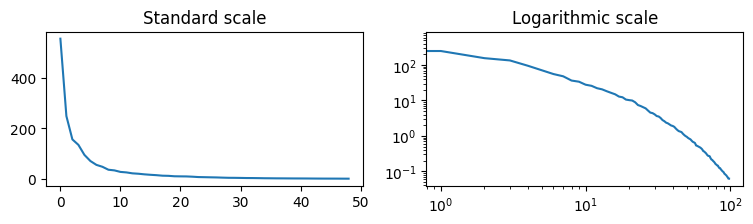

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (9, 2))
plt.subplot(1,2,1)
plt.plot(s[1:50])
plt.title("Standard scale")
plt.subplot(1,2,2)
plt.loglog(s[1:100])
plt.title("Logarithmic scale")
plt.show()

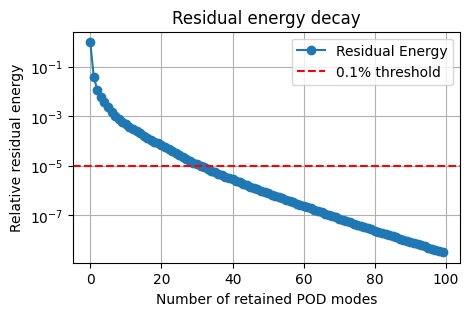

In [ ]:
import matplotlib.pyplot as plt

# Total energy (sum of all singular values squared)
total_energy = np.sum(s**2)

# Residual energy for each number of modes
residual_energy = np.cumsum(s[::-1]**2)[::-1] / total_energy

# Plot residual energy decay
plt.figure(figsize=(5, 3))
plt.plot(residual_energy[:100], 'o-', label='Residual Energy')
plt.xlabel("Number of retained POD modes")
plt.ylabel("Relative residual energy")
plt.title("Residual energy decay")
plt.grid(True)
plt.yscale("log")
plt.axhline(1e-5, color='red', linestyle='--', label='0.1% threshold')
plt.legend()
plt.show()


In [ ]:
# Desired energy retention level (e.g., 99.9% retained, 0.1% lost)
tolerance = 1e-5

# Compute total energy and residual energy as before
total_energy = np.sum(s**2)
residual_energy = np.cumsum(s[::-1]**2)[::-1] / total_energy

# Find smallest n such that residual energy is below tolerance
n_opt = np.argmax(residual_energy <= tolerance)

print(f"Selected number of POD modes (n): {n_opt}")
print(f"Corresponding residual energy: {residual_energy[n_opt]:.2e}")


Selected number of POD modes (n): 32
Corresponding residual energy: 8.56e-06


<font color='Orange'> Residual energy tells you how much information (energy) is not captured by your reduced basis (POD modes). It is a measure of the loss in the reduced approximation.

In [ ]:
n =32
V = X[:, :n]

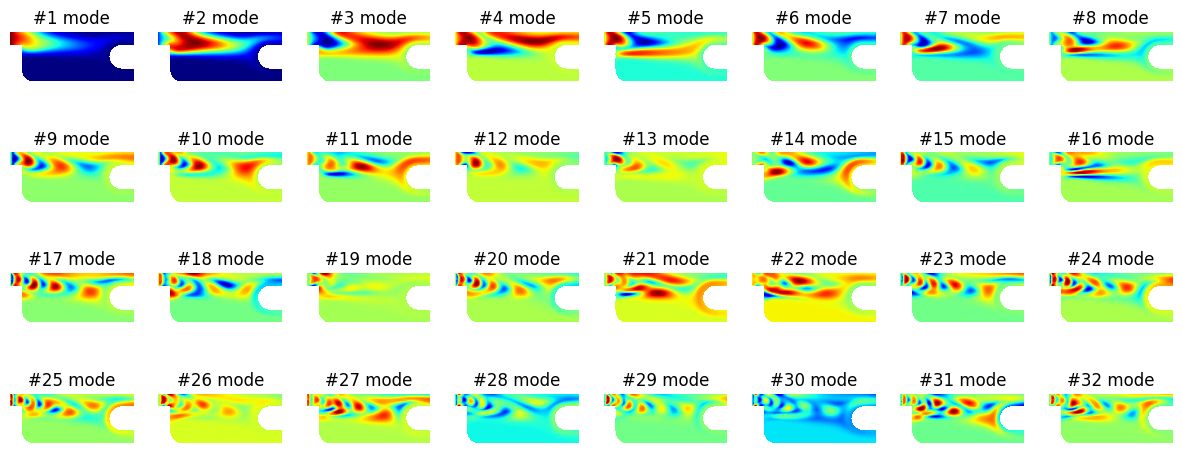

In [ ]:
plt.figure(figsize = (15, 6))
for k in range(n):
  plt.subplot(4, n//4, k+1)
  fe.plot(V[:, k], Vh)
  plt.title("#%d mode" % (k+1))
plt.show()

In [ ]:
from dlroms import num2p
Utest = uhom[ntrain:].reshape(-1, Vh.dim()).T
Uproj = V @ (V.T @ Utest) #offline projection error
#It measures how well a fixed reduced basis approximates your FOM snapshots.

errors = np.linalg.norm(Utest - Uproj, axis = 0) / np.linalg.norm(Utest, axis = 0)

ntest = uhom.shape[0] - ntrain
errors = errors.reshape(ntest, uhom.shape[1])

print("Average projection error: %s." % num2p(errors.max(axis = 1).mean()))

Average projection error: 1.88%.


# <font color='yellow'>Task iii)

In [ ]:
from dispenser import assemble_FOM_matrices

M, S, B1, B2, B3 = assemble_FOM_matrices()

Mrb  = V.T @ M  @ V
Srb  = V.T @ S  @ V
B1rb = V.T @ B1 @ V
B2rb = V.T @ B2 @ V
B3rb = V.T @ B3 @ V


In [ ]:
def RBstep(cn, dt, mu):
    c1, c2, c3 = mu
    Arb = Mrb + dt * Srb + dt * (c1 * B1rb + c2 * B2rb + c3 * B3rb)
    Frb = Mrb @ cn
    return np.linalg.solve(Arb, Frb)

In [ ]:
u0 = u0j
u0.shape

(1940,)

In [ ]:
def RBsolver(mu, dt=5e-4, steps=700):
    c0 = V.T @ u0  # Project initial condition to reduced space
    c = [c0]

    for _ in range(steps):
        c.append(RBstep(c[-1], dt, mu))

    c = np.stack(c)
    u = c @ V.T # lifting to FOM
    u[0] = u0  # Set initial condition back in full space
    return u

In [ ]:
mu0 = np.array([40, 20, 30])
uFOM = FOMsolverhom(*mu0)
uRB = RBsolver(mu0)

Average amount of chemical that has exited the domain (FOM): -0.97691
Average amount of chemical that has exited the domain (RB):  -0.97899


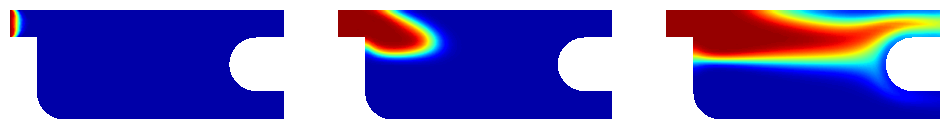

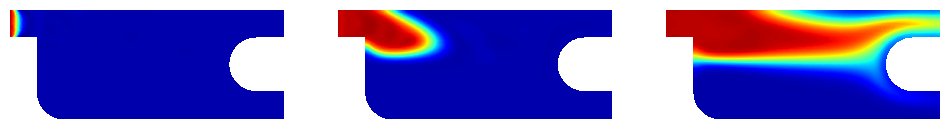

In [ ]:
#fe.multiplot(uRB[[10, 200, 700]], (1, 3),Vh)
fe.multiplot(uFOM[0][[10, 200, 700]], (1, 3), Vh, vmin=uFOM[0].min(), vmax=uFOM[0].max())
fe.multiplot(uRB[[10, 200, 700]],  (1, 3),Vh, vmin=uRB.min(), vmax=uRB.max())

j_fom = bottomOutflow(uFOM[0])
print(f"Average amount of chemical that has exited the domain (FOM): {j_fom:.5f}")

j_rb = bottomOutflow(uRB)
print(f"Average amount of chemical that has exited the domain (RB):  {j_rb:.5f}")


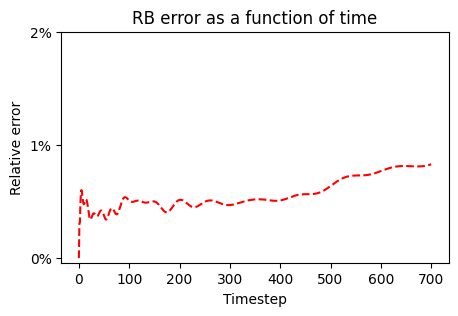

In [ ]:
errors = np.linalg.norm(uFOM[0] - uRB, axis=1) / np.linalg.norm(uFOM[0], axis=1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
plt.yticks([0, 0.01, 0.02], ["0%", "1%", "2%"])
plt.show()

In [ ]:
from time import perf_counter
t0 = perf_counter()
FOMsolverhom(*mu0)
t1 = perf_counter()
dtFOM = t1 - t0
print("FOM evaluation time: %.2f milliseconds." % (1000*dtFOM))

t0 = perf_counter()
RBsolver(mu0)
t1 = perf_counter()
dtROM = t1 - t0
print("ROM evaluation time: %.2f milliseconds." % (1000*dtROM))
print("\n>> Boost: x%d." % (dtFOM//dtROM))

FOM evaluation time: 13129.37 milliseconds.
ROM evaluation time: 30.56 milliseconds.

>> Boost: x429.


In [ ]:
Utest = uhom[ntrain:]
URBtest = [RBsolver(m) for m in c[ntrain:]]

URBtest = np.stack(URBtest)
errors = np.linalg.norm(Utest-URBtest, axis = -1)/np.linalg.norm(Utest, axis = -1)
etest = errors.max(axis = -1).mean()

print("Average uniform relative error: %s." % num2p(etest))

Average uniform relative error: 2.04%.


In [ ]:
from time import time
from matplotlib import pyplot as plt

# Store time-resolved errors
timewise_errors_all = []
rel_errors_timewise = []
times_fom = []
times_rb = []
J_errors = []

# Use 10 test samples from your dataset
mu_test = c[ntrain:]

for j, mu in enumerate(mu_test):
    # FOM
    t0 = time()
    u_fom, u0j = FOMsolverhom(*mu, steps=700, dt=5e-4)
    times_fom.append(time() - t0)
    J_fom = bottomOutflow(u_fom)

    # RB
    u0 = u0j
    t0 = time()
    u_rb = RBsolver(mu, dt=5e-4, steps=700)
    times_rb.append(time() - t0)
    J_rb = bottomOutflow(u_rb)

    # Compute relative error per timestep
    rel_error_t = np.linalg.norm(u_fom - u_rb, axis=1) / np.linalg.norm(u_fom, axis=1)
    timewise_errors_all.append(rel_error_t)
    rel_errors_timewise.append(np.mean(rel_error_t))  # avg error per simulation

    # Relative error in functional
    err_J = abs(J_fom - J_rb) / abs(J_fom)
    J_errors.append(err_J)

# Convert to array
timewise_errors_all = np.array(timewise_errors_all)


In [ ]:
import numpy as np

print(f"\nAverage FOM time: {np.mean(times_fom):.3f} s")
print(f"Average RB time: {np.mean(times_rb):.3f} s")
print(f"Average Speedup factor: {np.mean(times_fom) / np.mean(times_rb):.1f}x")



Average FOM time: 13.360 s
Average RB time: 0.037 s
Average Speedup factor: 365.6x


In [ ]:
rel_errors_timewise = np.array(rel_errors_timewise)
print(f"\nAverage relative error over the test set: {np.mean(rel_errors_timewise):.3%}")
print(f"Max relative error across simulations: {np.max(rel_errors_timewise):.3%}")
print(f"Standard deviation of relative errors: {np.std(rel_errors_timewise):.3%}")



Average relative error over the test set: 0.967%
Max relative error across simulations: 4.388%
Standard deviation of relative errors: 1.168%


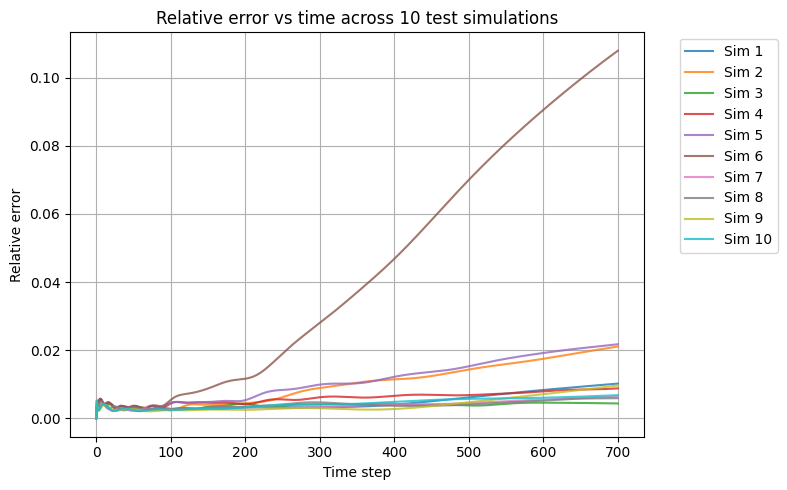

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for j in range(len(mu_test)):  # or simply: range(10)
    plt.plot(timewise_errors_all[j], label=f"Sim {j+1}", alpha=0.8)

plt.xlabel("Time step")
plt.ylabel("Relative error")
plt.title("Relative error vs time across 10 test simulations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.grid(True)
plt.tight_layout()
plt.show()


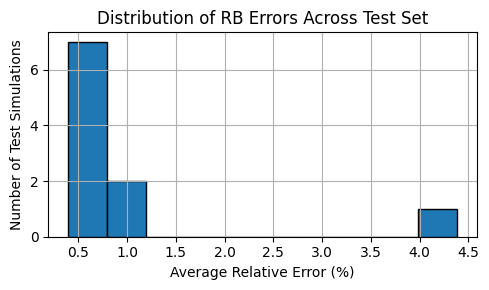

In [ ]:
plt.figure(figsize=(5,3))
plt.hist(rel_errors_timewise * 100, bins=10, edgecolor='k')
plt.xlabel("Average Relative Error (%)")
plt.ylabel("Number of Test Simulations")
plt.title("Distribution of RB Errors Across Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Average relative error in J:", np.mean(J_errors))
print("Max relative error in J:", np.max(J_errors))

Average relative error in J: 0.007932766198154783
Max relative error in J: 0.05730988764342156


# <font color='yellow'>Task vi)

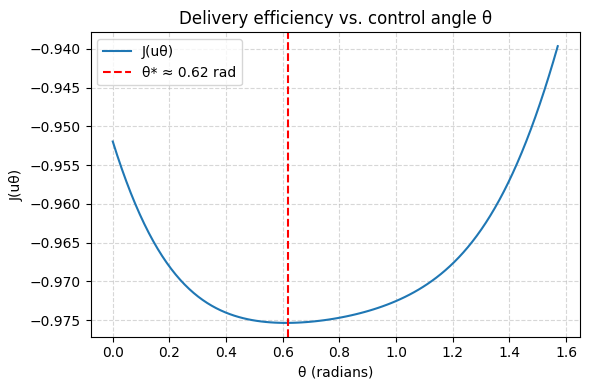

Optimal θ* ≈ 0.6188 radians ≈ 35.45 degrees
Minimum J(uθ) ≈ -0.975364


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dispenser import bottomOutflow

# Define parameters
c1 = 50
theta_vals = np.linspace(0, np.pi / 2, 100)
J_vals = []

# Loop over θ values
for theta in theta_vals:
    c2 = 50*np.cos(theta)
    c3 = 50*np.sin(theta)
    mu = [c1, c2, c3]

    u_theta = RBsolver(mu, dt=5e-4, steps=700)  # same dt and steps as FOM
    J_val = bottomOutflow(u_theta)
    J_vals.append(J_val)

# Find the optimal theta
theta_star_index = np.argmin(J_vals)
theta_star = theta_vals[theta_star_index]
J_min = J_vals[theta_star_index]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(theta_vals, J_vals, label='J(uθ)')
plt.axvline(theta_star, color='r', linestyle='--', label=f'θ* ≈ {theta_star:.2f} rad')
plt.xlabel("θ (radians)")
plt.ylabel("J(uθ)")
plt.title("Delivery efficiency vs. control angle θ")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Optimal θ* ≈ {theta_star:.4f} radians ≈ {np.degrees(theta_star):.2f} degrees")
print(f"Minimum J(uθ) ≈ {J_min:.6f}")